In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
from scipy.stats import skew
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import kagglehub
from sklearn.preprocessing import PowerTransformer

# Task Description

The objective is to train an ML model to predict medical charges given a patients medical record that includes where they are from. This will be a regression problem as medical charges can be seen as continious value, So using regression models along with metrics such as mean squared error (MSE) and the mean absolute error (MAE) will be the main focus for this project.

In [2]:
df = pd.read_csv('DataSet\medical-charges.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Dataset Info

The datset contains 1338 rows which seems to consist of different patients and their medical records, which means that this dataset is relitively small, which means that it is susceptable to overfitting, however by training a small model with the use of regularization the risk of overfitting can be reduced despite the dataset being small.

Furhtermore, there are no missing values in this dataset which means that there will be no need to drop rows or fill in rows with the mean etc. However, certain columns, for example 'smoker' or 'region', need to be formatted into numerical columns before training an ML model.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Target analysis

The distribution for the charges column has a right skew of skew value 1.5, this skewness can affect the ML models predictions due to large values distorting the model's predictions, furhtermore, the model can become bias two lower charges and perform poorly on the outliers in the distribution. To combat this problemm, a log transformation will be applied as it does reduce the skewness of the charges distribution to a skew value of -0.08, which means that the target distribution is more uniform than before. For the of comparison, ML models will be trained on both the original target distribution and the transformed distrubtion.  

<Axes: xlabel='charges', ylabel='Count'>

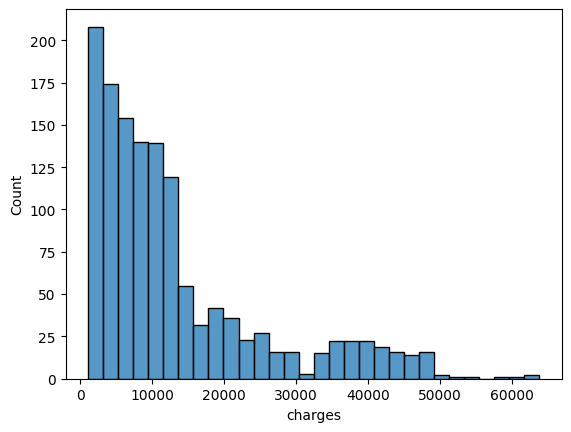

In [4]:
sns.histplot(data = df, x = 'charges')

In [5]:
print("skew:", skew(df['charges']))

skew: 1.5141797118745743


<Axes: xlabel='charges', ylabel='Count'>

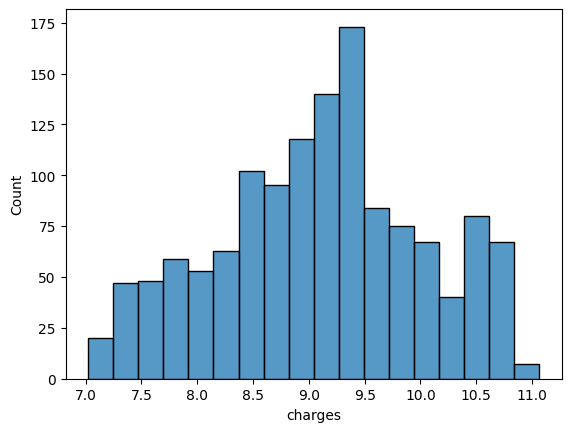

In [6]:
sns.histplot( x = np.log(df['charges']))

In [7]:
print("skew:", skew(np.log(df['charges'])))

skew: -0.08999648706579091


In [8]:
percentages = [0.25,0.5,0.75, 0.90, 0.95,0.99, 1]
df['charges'].quantile(q = percentages)

0.25     4740.287150
0.50     9382.033000
0.75    16639.912515
0.90    34831.719700
0.95    41181.827787
0.99    48537.480726
1.00    63770.428010
Name: charges, dtype: float64

# Effect of smoking

This dataset does consist of more non-smokers than smokers, with nearly %80 of the dataset being non-smokers. Analysing plots and statistics of the relationship between smoking and charges a patient inccurs, there is a signal that highlights, smokers being charged more than non-smokers. The mean charge that non-smokers pay is close to ~\$8434, where as the mean charge that smoker have to pay is 3.8x the amount of non-smokers which is ~32050. Furthermore, the medians of the two also showcases the contrast of charges between smokers and non-smokers. The median for non-smokers is ~7345 and for smokers the median is ~34456. As shown by both the plots and by the mean and median, there is a strong signal between smokers and the increase of charges, therfore this feature will be included to train the model and in combination with some of the other features it can help the model make better predictions.  

- This dataset consists of ~79.5% of the entries being non-smoker and ~20.5 of the entries being smokers
- juding of the various plots and statistics non-smokers face signicantly less charges, mention mean and median


<Axes: xlabel='smoker', ylabel='count'>

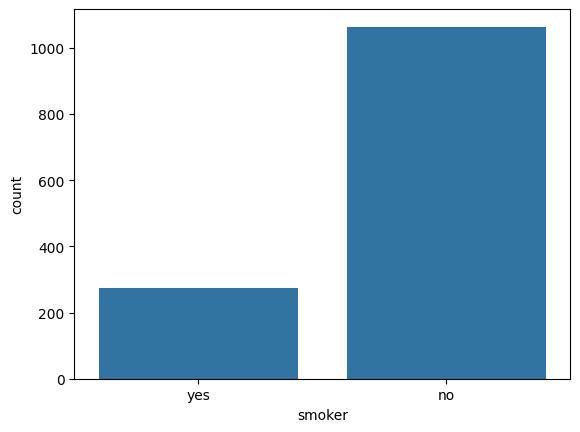

In [9]:
sns.countplot(data = df, x = 'smoker')

In [10]:
df['smoker'].value_counts(normalize= True)

smoker
no     0.795217
yes    0.204783
Name: proportion, dtype: float64

<Axes: xlabel='charges', ylabel='smoker'>

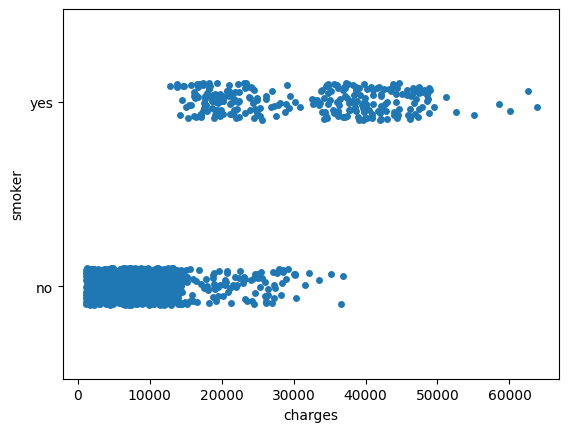

In [11]:
sns.stripplot(data = df, x = 'charges', y = 'smoker')

<Axes: xlabel='smoker', ylabel='charges'>

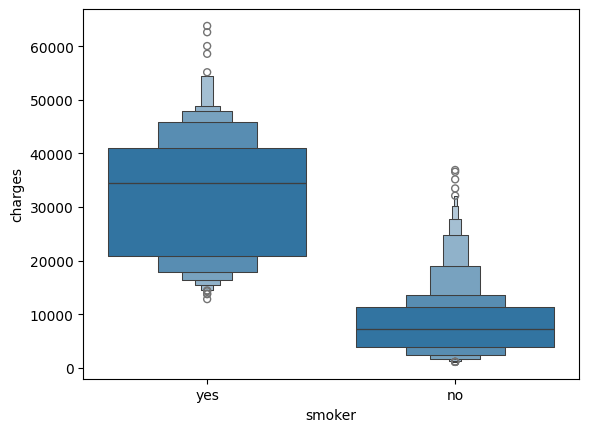

In [12]:
sns.boxenplot(data = df, x = 'smoker', y = 'charges')

In [13]:
df.groupby('smoker')['charges'].mean()


smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

In [14]:
df.groupby('smoker')['charges'].median()

smoker
no      7345.40530
yes    34456.34845
Name: charges, dtype: float64

In [15]:
percentages = [0.25,0.5,0.75, 0.90, 0.95,0.99, 1]
df.groupby('smoker')['charges'].quantile(q = percentages)

smoker      
no      0.25     3986.438700
        0.50     7345.405300
        0.75    11362.887050
        0.90    14340.607380
        0.95    20864.190103
        0.99    29020.574733
        1.00    36910.608030
yes     0.25    20826.244213
        0.50    34456.348450
        0.75    41019.207275
        0.90    46642.742200
        0.95    48528.628470
        0.99    58962.662092
        1.00    63770.428010
Name: charges, dtype: float64

# Effect of Region

The regions within this dataset are close to being evenly spread, with the southeast having slightly more entries than the rest of the region. The region feature as an individual feature does not have a strong signal in causing charges to increase or even decrease. There is overlap accross all regions, and every region has a similar mean and median, although there is slight variance it is not indicative of regions having affect on charges, as showcased in the boxplot. While this feature alone, may not show any predictive power, if combined with other features may prove to uncover hidden relationships which may improve the model's ability to predict accurately. 


<Axes: xlabel='region', ylabel='count'>

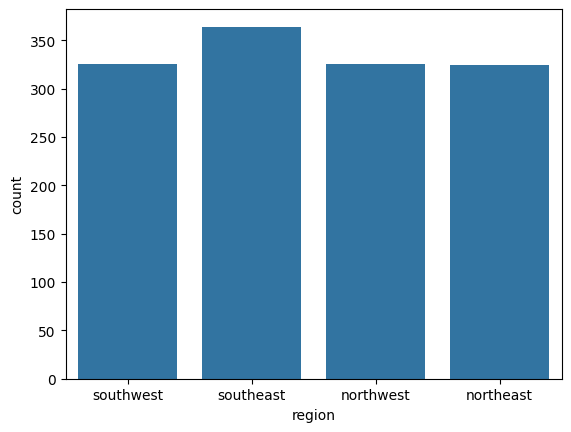

In [16]:
sns.countplot(data = df, x = 'region')

In [17]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

<Axes: xlabel='charges', ylabel='region'>

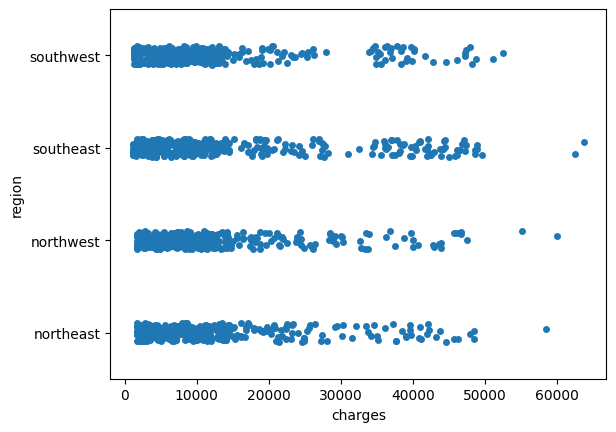

In [18]:
sns.stripplot(data = df, x = 'charges', y = 'region')

<Axes: xlabel='region', ylabel='charges'>

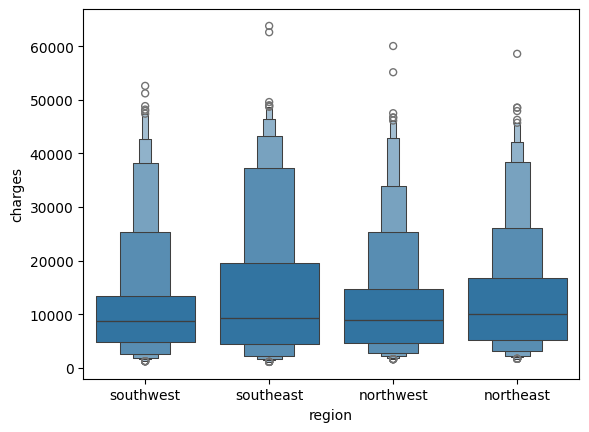

In [19]:
sns.boxenplot(data = df, x = 'region', y = 'charges')

In [20]:
df.groupby('region')['charges'].mean()

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64

In [21]:
df.groupby('region')['charges'].median()

region
northeast    10057.652025
northwest     8965.795750
southeast     9294.131950
southwest     8798.593000
Name: charges, dtype: float64

In [22]:
percentages = [0.25,0.5,0.75, 0.90, 0.95,0.99, 1]
df.groupby('region')['charges'].quantile(q = percentages)

region         
northeast  0.25     5194.322288
           0.50    10057.652025
           0.75    16687.364100
           0.90    31211.999410
           0.95    39591.270295
           0.99    47519.205214
           1.00    58571.074480
northwest  0.25     4719.736550
           0.50     8965.795750
           0.75    14711.743800
           0.90    28901.347712
           0.95    38490.152830
           0.99    46704.550246
           1.00    60021.398970
southeast  0.25     4440.886200
           0.50     9294.131950
           0.75    19526.286900
           0.90    39827.016870
           0.95    44379.457925
           0.99    48916.627046
           1.00    63770.428010
southwest  0.25     4751.070000
           0.50     8798.593000
           0.75    13462.520000
           0.90    34809.038400
           0.95    39192.862800
           0.99    48114.481560
           1.00    52590.829390
Name: charges, dtype: float64

# Age
The age feature does seem to have some signal that indicates that as age increases charges also increase. However as shown in both the scater plot and the density plot, there are multiple bands of charges for the age feature, this suggest that there may be a non-linear relationship between the age feature and charges that a non-linear model can learn. Therfore, during the ML part of this project both a linear model and a non-linear model will be trainined and their results compared. 


<Axes: xlabel='age', ylabel='charges'>

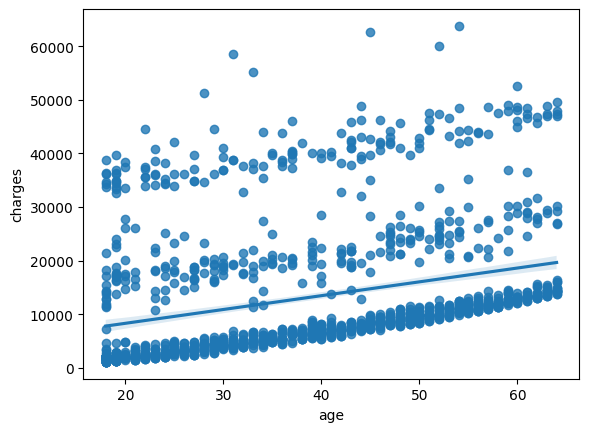

In [23]:
sns.regplot(data = df, x = 'age', y = 'charges')

<Axes: xlabel='age', ylabel='charges'>

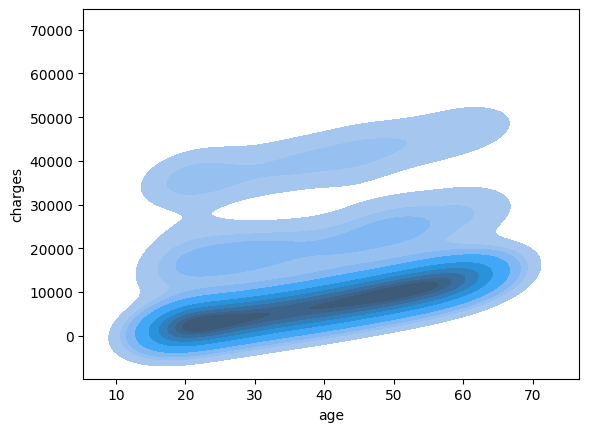

In [24]:
sns.kdeplot(data = df, x = 'age', y = 'charges', fill = True)

# BMI
what can be seen from the scatter plot and density plot used to showcase any relationship between the BMI feature and the charges, is that there are not any underlying patterns that would suggest that the BMI feature has any affects on the charges, however, in the density plot there are signs of a non-linear relationship. While the BMI feature does not produce a strong signal, if combined with features like "smokers" and "age", there could be underlying patterns that become unearthed. Furhtermore, due to their potentially being a non-linear relationship between the BMI feature and the charges target feature this feature will also be included in the training of the non-linear ML model.



<Axes: xlabel='bmi', ylabel='charges'>

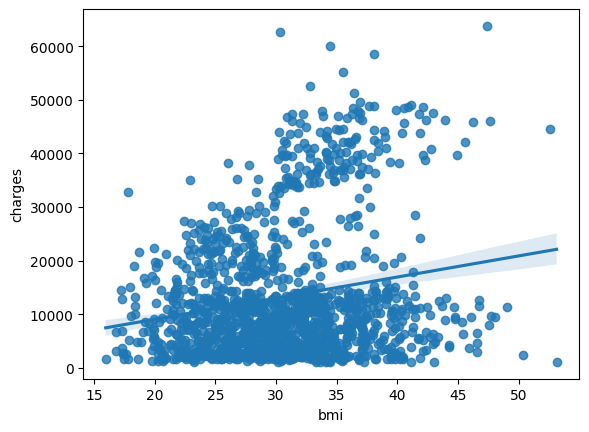

In [25]:
sns.regplot(data = df, x = 'bmi', y = 'charges')

<Axes: xlabel='bmi', ylabel='charges'>

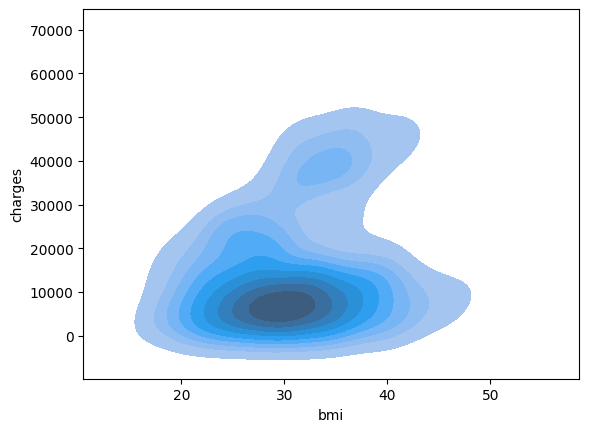

In [26]:
sns.kdeplot(data = df, x = 'bmi', y = 'charges', fill = True)

# Effects of number of children
When analysing the the 'number of children' feature, no significant signal was found. Each children number category had relatively the same mean and median and the distributions of each children category in box plot and the strip plot showcase similar shapes with no monotonic increase. While there are no signs of this feature having a strong influence on the final charges, using this feature in combination with other features may provide enough signal for the ML model.


<Axes: xlabel='children', ylabel='charges'>

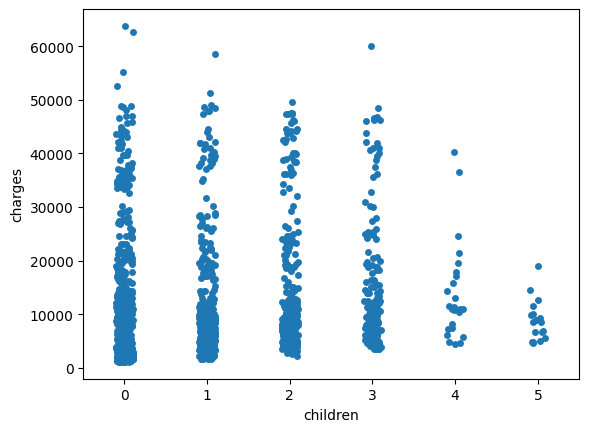

In [27]:
sns.stripplot(data = df, x = 'children', y = 'charges')

<Axes: xlabel='children', ylabel='charges'>

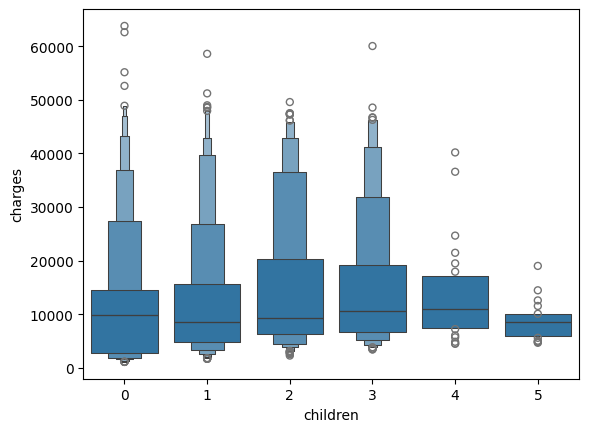

In [28]:
sns.boxenplot(data = df, x = 'children', y = 'charges')

# Effect of gender on charges

The distribution of both genders are new equal with there being a small of more males within this dataset. Once again as an individual features, it does not provide a strong signal as there is noticeable overlap between males and females, males and females have the same mean and median of charges, however something to notice is that while both males and females have a similar charge distribution and both do have outliers, males tend to have more variability. This feature on its own does not provide a strong enough signal to determine if it has an effect on charges, however when paired with features like 'children' and other may uncover some hidden information which the ML model can use when making its prediction.   

<Axes: xlabel='sex', ylabel='count'>

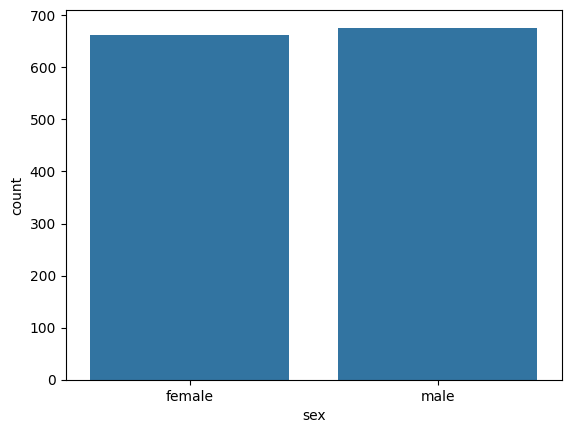

In [29]:
sns.countplot(data = df, x = 'sex')

<Axes: xlabel='charges', ylabel='sex'>

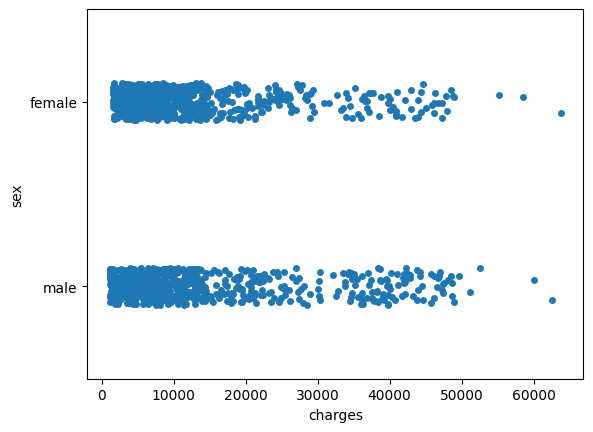

In [30]:
sns.stripplot(data = df, x = 'charges', y = 'sex')

<Axes: xlabel='sex', ylabel='charges'>

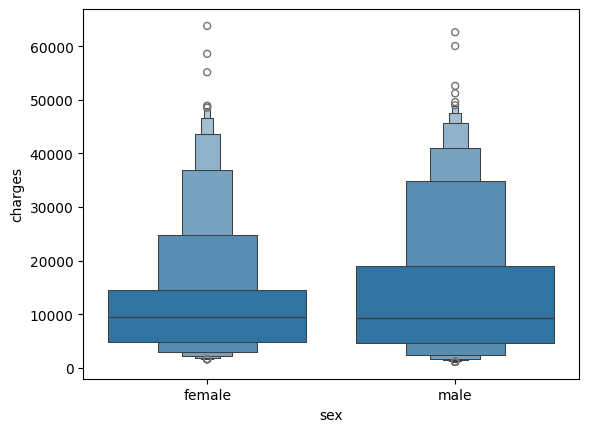

In [31]:
sns.boxenplot(data = df, x='sex', y = 'charges')

In [32]:
df.groupby('sex')['charges'].mean()

sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64

In [33]:
df.groupby('sex')['charges'].median()

sex
female    9412.96250
male      9369.61575
Name: charges, dtype: float64

# Cleaning and Formatting Data

Since there are no missing values, rows do not need to be dropped or permutated. However, specific feature columns like: 'sex', 'smoker', 'region', etc, Require converting into numerical values. In this case smokers and sex will be mapped to binary and 'pd.get_dummies' will be applied to the region column to turn each category into its own column.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [35]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [36]:
df['sex'] = df['sex'].map({'female' : 0, 'male': 1})
df['smoker'] = df['smoker'].map({'no' : 0, 'yes': 1})

In [37]:
df = pd.get_dummies(data = df, columns = ['region'])

In [38]:
boolCols = ['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
df[boolCols] = df[boolCols].astype(int)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex               1338 non-null   int64  
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   int64  
 4   smoker            1338 non-null   int64  
 5   charges           1338 non-null   float64
 6   region_northeast  1338 non-null   int64  
 7   region_northwest  1338 non-null   int64  
 8   region_southeast  1338 non-null   int64  
 9   region_southwest  1338 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 104.7 KB


# Model Setup and Training

In [40]:
from sklearn.model_selection import train_test_split
X = df.drop('charges', axis = 1)
y = df['charges']

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# BaseLine Predictor

In [41]:
y_pred_baseline = np.full(
    shape=len(y_test),
    fill_value=y_train.mean()
)

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_baseline)
mse = mean_squared_error(y_test, y_pred_baseline)

print("Baseline MAE:", mae)
print("Baseline mse:", mse)

Baseline MAE: 9593.33846086229
Baseline mse: 155391443.68461317


# Training Linear regression model on orginal target distributions

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

model = LinearRegression(fit_intercept=True, copy_X = True)
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [44]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse, ',MAE: ',mae )

MSE:  33596915.85136146 ,MAE:  4181.194473753641


# Training linear reg on log transformed target distribution



In [45]:
transformed_df = df.copy()
transformed_df['charges'] = np.log(transformed_df['charges'])

In [46]:
from sklearn.model_selection import train_test_split
X = transformed_df.drop('charges', axis = 1)
y = transformed_df['charges']

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [47]:
tran_lin_model = LinearRegression(fit_intercept=True, copy_X = True)
tran_lin_model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [48]:
y_log_pred = tran_lin_model.predict(X_test)

y_pred = np.exp(y_log_pred)
y_true_test = np.exp(y_test)

mae = mean_absolute_error(y_true_test, y_pred)
mse = mean_squared_error(y_true_test, y_pred)
print('MSE: ', mse, ',MAE: ',mae )

MSE:  61079027.741165735 ,MAE:  3888.7707805158716


# Training Random Forest Algorithm on original target distribution

In [49]:
rfr = RandomForestRegressor()

In [50]:
rfr.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [51]:
y_pred = rfr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse, ',MAE: ',mae)

MSE:  0.13793671615909206 ,MAE:  0.18722058456768045


# Training Random Forest Algorithm on log transformed target distribution

In [52]:
rfr.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [53]:
y_log_pred = rfr.predict(X_test)

y_pred = np.exp(y_log_pred)
y_true_test = np.exp(y_test)

mae = mean_absolute_error(y_true_test, y_pred)
mse = mean_squared_error(y_true_test, y_pred)
print('MSE: ', mse, ',MAE: ',mae )

MSE:  19586187.67983611 ,MAE:  2072.029229340344


# Training GradientBoostingRegressor on original target distribution 

In [54]:
from sklearn.ensemble import GradientBoostingRegressor 

In [55]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

In [56]:
y_pred = gb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse, ',MAE: ',mae) 

MSE:  0.12329402053636096 ,MAE:  0.18863079639641933


# Training GradientBoostingRegressor on transformed target distribution 

In [57]:
gb_model.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

In [58]:
y_log_pred = gb_model.predict(X_test)

y_pred = np.exp(y_log_pred)
y_true_test = np.exp(y_test)

mae = mean_absolute_error(y_true_test, y_pred)
mse = mean_squared_error(y_true_test, y_pred)
print('MSE: ', mse, ',MAE: ',mae )

MSE:  20133030.470889337 ,MAE:  2079.302177649629


# Results Summary

There were three ML models that were trained on this dataset, the model were: a Linear regression model, a random forest algorithm and an Xgboost algorithm. All three were first trained on the original target distribution and then were trained on the log transformed target distribution and the performances of each model were measured using the MSE and MAE metrics. Before discussing the results, a baseline predictor using the mean for each charge a patient had in the dataset was tested and it produced an MSE of ~155391443 and an MAE of ~9593. 

it is safe to say that all three ML models performed better than the baseline so patterns were identified by the ML model in which they their predictions, to what degree will be discussed next.

## Linear Regression
#### Original target distribution

MAE: ~4181
MSE: ~33596915

#### Log-Transformed target distribution

MAE: ~3888
MSE: ~61079027

## Random Forest Algorithm
#### Original target distribution

MAE: ~2470
MSE: ~20743836

#### Log-Transformed target distribution

MAE: ~2103
MSE: ~19644057

## XGBoost
#### Original target distribution

MAE: ~2407
MSE: ~18755718

#### Log-Transformed target distribution

MAE: ~2077
MSE: ~20098771


# Results analysis

A linear regression model was first trained and produced the results above however, both the MSE and MAE were significantly improved when the tree algorithms were trained on this dataset. This is due to the non-linear relationships between the input features and charges that both the random forest algorithm and XGBoost identify during training that the linear regression model does not. 

Now analysing the metrics all models record MAE scores that are significantly lower than the MSE scores, which indicate that all the models predictions for most of the inputs are not too far off the actual however, all models fail to accurately predict large charges. This could be due to models having bias toward low charges, such is the target distribution, where most inputs have low charges however there are inputs that incur uncommonly large charges. This is also highlighted in the quantile analysis for the target distributions that show a massive difference in charges just within the last %10 and even the last %1. 

Moving on to the effects of transforming the distributions, each model's mean absolute value improved however, the mean squared error increased for the linear regression model, slighlty improves for the random forest algorithm and slightly increases for the XGBoost algorithm. This may mean that transforming the model may provide stability and a better ability to predict accurately across all charges, however in some cases amplify the issues of predicting large values, due to the transformation squashing larger values closer to the mean for a more uniform distribution.

Out of the three models, the XGBoost performed the best getting the lowest MSE score when it was trained on the original target distribution and the lowest MAE score when trained on the log-transformed target distribution. This can be due to the non-linear relationships that the XGBoost indetifies during training which surpasses in performance when compared to a linear model and becuase it is much more of a complex tree algorithm when compared with the random forest algorithm (RFA), which allows the XGBoost model to learn realtionships and patterns that the RFA fails to learn and apply. 


# Conclusion 

When looking at the two metrics MSE and MAE, one must make the decsion on what the business prioritises. Do they want a model that can correctly assign charges to most of the patients but fail to accuractely assign charges to unique patients that may require to pay more for services. If a business wants a model that is generally good then the MAE metric will be prioritised, therefore the XGBoost model would be the model of choice in this case, however if a business priorites, that the model must accurately assign charges to patient that have unique circumstance which requires to pay more for services, then all three models will struggle to perform well for that purpose. 

For future work, optimally tuning the hyperparameters for each model could possibily squeeze out better performance from each model, moreover, scaling both model and dataset can provide for a better performing ML algorithm.